In [51]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [52]:
import eigen_analysis

cols = eigen_analysis.LINUX_COLS
time_unit = eigen_analysis.TIME_CONVERSION_khz
joules_unit = eigen_analysis.JOULE_CONVERSION

In [53]:
# get all itrs explored for some (dvfs, qps) pair
def list_itrs(rdtsc_dirname):
    itrs = []
    for file in os.listdir(rdtsc_dirname):
        tags = file.split('_')
        itr = tags[1]
        itrs.append(itr)
    itrs = list(set(itrs))
    return itrs

In [114]:
app = 'mcdsilo'
run = '0'
rapl = '135'

In [115]:
app_dir = app + '_' + run + '_rapl_' + rapl + '/'
dvfs = '0x1300'
logs_dir = app_dir + qps + '_qps/linux_' + app + '_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
cores = []
cores = !ls $logs_dir | cut -d '_' -f2 | sort | uniq
#cores = [c for c in range(0, 16)]

In [116]:
global itrs
global cores
global app_dir

In [117]:
cores

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [118]:
def print_err_log(dvfs, qps, itr, rapl='135', run='0', err_dir = app_dir + 'err_logs/'):
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    if os.path.exists(err_dir + err_filename):
        err_file = open(err_dir + err_filename, 'r')
        print(err_file.read())
    else:
        print('EMPTY ERROR LOG')

In [119]:
def handle_neg_diffs(df_diffs, df, core, err_file):
    
    tmp = df_diffs.copy()

    # isolating rows with negative diffs
    tmp_neg = tmp[(tmp['joules_diff'] < 0) | (tmp['instructions_diff'] < 0) | (tmp['cycles_diff'] < 0) \
                   | (tmp['ref_cycles_diff'] < 0) | (tmp['llc_miss_diff'] < 0) | (tmp['timestamp_diff'] < 0)]

    # re-computing diffs if possible; else dropping rows
    for i,j in tmp_neg.iterrows():
        prev = df.shift(1).loc[i]
        cur = df.loc[i]
        # TODO note that we are only handling case of RAPL-energy-status register overflow
        if (tmp.loc[i]['joules_diff'] < 0) & (tmp.loc[i]['timestamp_diff'] >= 0.001):
            err_file.write('CORE ' + str(core) + '  ---  JOULES COUNTER OVERFLOW AT LOG ENTRY DIFF #' + str(i) + '\n')
            tmp.loc[i, ['joules_diff']] = (2**32 - 1) * joules_unit - prev['joules'] + cur['joules'] 
        else:
            err_file.write('CORE ' + str(core) + '  ---  UNEXPLAINED NEGATIVE VALS AT LOG ENTRY DIFF # ' + str(i) + '\n')
            cols = ''
            prevs = ''
            currs = ''
            for col in list(df.columns):
                cols += col + '  '
                prevs += str(prev[col]) + '  '
                currs += str(cur[col]) + '  '
            err_file.write('          ' + cols + '\n')
            err_file.write('         log[' + str(i-1) + ']: ' + prevs + '\n')
            err_file.write('         log[' + str(i) + ']: ' + currs + '\n')
            tmp = tmp.drop(i, axis=0)

    return tmp

### Correlation matrices and eigenvals:

In [120]:
def per_core_corr(dvfs, qps, itr, app, rapl='135', run='0'):

    counters_corr_dict = {}
    non_counters_corr_dict = {}

    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    # here are all the log files for this dvfs & qps
    logs_dir = app_dir + qps + '_qps/linux_' + app + '_dmesg_' + run + '_' + dvfs + '_' + rapl + '_' + qps + '/'
    # here are all the time-management files for this dvfs & qps
    rdtsc_dir = app_dir + qps + '_qps/linux_' + app + '_rdtsc_' + run + '_' + dvfs + '_' + rapl + '_' + qps +'/'
    rdtsc_file = rdtsc_dir + 'linux.' + app + '.rdtsc.' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    start, end = eigen_analysis.get_rdtsc(rdtsc_file)

    # initializing error log file
    err_dir = app_dir + 'err_logs/'
    err_filename = 'err_log_' + run + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
    err_file = open(err_dir + err_filename, 'w')

    cores = []
    cores = !ls $logs_dir | cut -d '_' -f2 | sort | uniq
    #cores = [c for c in range(0, 16)]
    for c in cores:
        file = logs_dir + 'linux.' + app + '.dmesg.' + run + '_' + str(c) + '_' + itr + '_' + dvfs + '_' + rapl + '_' + qps[:-1] + '000'
        
        print('Uncompressing log file..')
        !gunzip -v $file'.gz'    
        df = pd.read_csv(file, sep = ' ', names = cols, index_col='i')
        print('Compressing log file..')
        !gzip -v9 $file
        
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        df.loc[:, 'timestamp'] = df['timestamp'] - df['timestamp'].min()
        df.loc[:, 'timestamp'] = df['timestamp'] * time_unit
        df.loc[:, 'joules'] = df['joules'] * joules_unit
        
        counters_df = df[['joules', 'instructions', 'cycles', 'ref_cycles', 'llc_miss', 'timestamp']].copy()
        counters_df = counters_df[(counters_df['joules'] > 0) & (counters_df['instructions'] > 0) \
                                            & (counters_df['cycles'] > 0) & (counters_df['ref_cycles'] > 0) \
                                            & (counters_df['llc_miss'] > 0)]
        # computing diffs of counter readings
        df_diffs = counters_df.diff().dropna().copy()
        df_diffs.columns = [f'{c}_diff' for c in df_diffs.columns]
        df_diffs = handle_neg_diffs(df_diffs, counters_df, c, err_file)
        df_corr = df_diffs.drop(['timestamp_diff', 'joules_diff'], axis = 1).corr()
        counters_corr_dict[str(c)] = df_corr

        non_counters_df = df[['rx_bytes', 'rx_desc', 'tx_bytes', 'tx_desc']].copy()
        df_corr = non_counters_df.corr()
        non_counters_corr_dict[str(c)] = df_corr
        
    return counters_corr_dict, non_counters_corr_dict

In [121]:
def merged_core_corr(dvfs, qps, itr, app, rapl='135', run='0'):
    app_dir = app + '_' + run + '_rapl_' + rapl + '/'
    merged_dir = app_dir + qps + '_merged/'
    merged_counters_dir = merged_dir + qps + '_' + dvfs + '_counters_merged/'
    merged_non_counters_dir = merged_dir + qps + '_' + dvfs + '_non_counters_merged/'
    merged_counters_file = merged_counters_dir + dvfs + '_' + qps + '_' + itr + '_counters_merged'
    merged_non_counters_file = merged_non_counters_dir + dvfs + '_' + qps + '_' + itr + '_non_counters_merged'
    print('Uncompressing merged log files..')
    !gunzip -v $merged_counters_file'.gz'    
    !gunzip -v $merged_non_counters_file'.gz'    
    counters_df = pd.read_csv(merged_counters_file, index_col=0)
    non_counters_df = pd.read_csv(merged_non_counters_file, index_col=0)
    counters_corr = counters_df.drop(['timestamp', 'joules_diff'], axis = 1).corr()
    print('Compressing merged log files..')
    !gzip -v9 $merged_counters_file    
    !gzip -v9 $merged_non_counters_file    

    non_counters_corr = non_counters_df.drop(['timestamp'], axis = 1).corr()
    
    return counters_corr, non_counters_corr

In [122]:
counters_corr, non_counters_corr = merged_core_corr('0x1300', '200k', '20', 'mcdsilo')

Uncompressing merged log files..
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_20_counters_merged.gz:	 65.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_20_counters_merged
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_20_non_counters_merged.gz:	 74.3% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_20_non_counters_merged
Compressing merged log files..
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_20_counters_merged:	 65.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_20_counters_merged.gz
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_20_non_counters_merged:	 74.3% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_20_non_counters_merged.gz


In [123]:
counters_corr

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.944658,0.944655,0.900707
cycles_diff,0.944658,1.000000,1.000000,0.942879
ref_cycles_diff,0.944655,1.000000,1.000000,0.942884
llc_miss_diff,0.900707,0.942879,0.942884,1.000000


In [124]:
non_counters_corr

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.980979,-0.607758,-0.610090
rx_desc,0.980979,1.000000,-0.617714,-0.620197
tx_bytes,-0.607758,-0.617714,1.000000,0.999187
tx_desc,-0.610090,-0.620197,0.999187,1.000000


In [125]:
dvfs = '0x1300'
qps = '200k'
itr = '20'
app = 'mcdsilo'
counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, itr, app)
merged_counters_corr, merged_non_counters_corr = merged_core_corr(dvfs, qps, itr, app)

Uncompressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_20_0x1300_135_200000.gz:	 80.6% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_20_0x1300_135_200000
Compressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_20_0x1300_135_200000:	 80.6% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_20_0x1300_135_200000.gz
Uncompressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_20_0x1300_135_200000.gz:	 80.4% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_20_0x1300_135_200000
Compressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_20_0x1300_135_200000:	 80.4% -- replaced with mcdsilo_0_rapl_135

Uncompressing merged log files..
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_20_counters_merged.gz:	 65.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_20_counters_merged
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_20_non_counters_merged.gz:	 74.3% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_20_non_counters_merged
Compressing merged log files..
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_20_counters_merged:	 65.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_20_counters_merged.gz
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_20_non_counters_merged:	 74.3% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_20_non_counters_merged.gz


In [126]:
counters_corr_dict['10']

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.952592,0.952591,0.918290
cycles_diff,0.952592,1.000000,1.000000,0.949897
ref_cycles_diff,0.952591,1.000000,1.000000,0.949896
llc_miss_diff,0.918290,0.949897,0.949896,1.000000


In [127]:
non_counters_corr_dict['10']

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.981065,-0.670637,-0.671434
rx_desc,0.981065,1.000000,-0.679852,-0.680795
tx_bytes,-0.670637,-0.679852,1.000000,0.999850
tx_desc,-0.671434,-0.680795,0.999850,1.000000


In [128]:
merged_counters_corr

,instructions_diff,cycles_diff,ref_cycles_diff,llc_miss_diff
instructions_diff,1.000000,0.944658,0.944655,0.900707
cycles_diff,0.944658,1.000000,1.000000,0.942879
ref_cycles_diff,0.944655,1.000000,1.000000,0.942884
llc_miss_diff,0.900707,0.942879,0.942884,1.000000


In [129]:
merged_non_counters_corr

,rx_bytes,rx_desc,tx_bytes,tx_desc
rx_bytes,1.000000,0.980979,-0.607758,-0.610090
rx_desc,0.980979,1.000000,-0.617714,-0.620197
tx_bytes,-0.607758,-0.617714,1.000000,0.999187
tx_desc,-0.610090,-0.620197,0.999187,1.000000


In [144]:
from numpy.linalg import eig, eigvalsh

def get_eig_vals(cores, counters_corr_dict, non_counters_corr_dict, merged_counters_corr, merged_non_counters_corr):
    all_core_eigvals = {}
    for c in cores:
        counter_vals, vecs = eig(counters_corr_dict[str(c)])
        for i in range(0, len(counter_vals)):
            counter_vals[i] = counter_vals[i] / counter_vals[0]
        non_counter_vals, vecs = eig(non_counters_corr_dict[str(c)])
        for i in range(0, len(non_counter_vals)):
            non_counter_vals[i] = non_counter_vals[i] / non_counter_vals[0]
        all_core_eigvals[str(c)] = np.concatenate([np.log(counter_vals[1:4]) , np.log(non_counter_vals[1:4])])
        #all_core_eigvals[str(c)] = np.concatenate([counter_vals , non_counter_vals])

    merged_counter_vals, merged_vecs = eig(merged_counters_corr)
    for i in range(0, len(merged_counter_vals)):
        merged_counter_vals[i] = merged_counter_vals[i] / merged_counter_vals[0]
    merged_non_counter_vals, merged_vecs = eig(merged_non_counters_corr)
    for i in range(0, len(merged_non_counter_vals)):
        merged_non_counter_vals[i] = merged_non_counter_vals[i] / merged_non_counter_vals[0]
    #all_core_eigvals['merged'] = np.concatenate([np.log(merged_counter_vals[1:4]), np.log(merged_non_counter_vals[1:4])])
    all_core_eigvals['merged'] = np.concatenate([merged_counter_vals[1:4], merged_non_counter_vals[1:4]])
    
    return all_core_eigvals

In [145]:
def plot_eig_vals(eig_dict, dvfs, qps, itr, app):
    plt.figure(figsize=(10,6))
    num_eig = len(list(eig_dict.values())[0])
    eig_list = [str(i) for i in range(0, num_eig)]
    for core in eig_dict.keys():
        vals = eig_dict[core]
        #print(vals)
        plt.plot(eig_list, vals, 'p')
    plt.plot(eig_list, eig_dict['merged'], 'x')    
    plt.xlabel('eig_id')
    plt.ylabel('eig_val')
    plt.ylim(-25)
    #plt.title(f'{app}: Eigvals of {len(cores) + 1} Corr Matrices for ITR-DELAY = {itr}, DVFS = {dvfs}, QPS = {qps}')
    plt.title(f'{app}: Eigvals (log=false) of {len(cores) + 1} Corr Matrices for ITR-DELAY = {itr}, DVFS = {dvfs}, QPS = {qps}')
    plt.show()
    plt.savefig(app_dir + 'plots/eigvals_'+ dvfs + '_' + qps + '_' + itr)

In [146]:
eig_vals = get_eig_vals(cores, counters_corr_dict, non_counters_corr_dict, merged_counters_corr, merged_non_counters_corr)

In [147]:
eig_vals

{'0': array([ -1.64422406,  -2.4779479 , -14.5886004 ,   0.46323053,
         -3.95623127,  -7.72305432]),
 '1': array([ -1.93666619,  -2.61017196, -15.77186453,   0.3689051 ,
         -4.05132579,  -8.05808904]),
 '10': array([ -2.20352355,  -2.73993516, -16.73504035,   0.30891093,
         -4.07126731,  -8.36476165]),
 '11': array([ -2.36829507,  -3.02683261, -16.05197142,   0.19536627,
         -4.11416538,  -8.69515371]),
 '12': array([ -1.98233016,  -2.56610631, -14.97092627,   0.36666918,
         -4.05113219,  -8.12985099]),
 '13': array([ -2.37257083,  -3.00401577, -20.07180251,   0.20427497,
         -4.08774583,  -8.71169116]),
 '14': array([ -2.39225664,  -2.87339998, -20.12185428,   0.25199274,
         -4.14458709,  -8.64391776]),
 '2': array([ -2.52255161,  -3.00687966, -15.26489708,   0.14759941,
         -4.04861854,  -8.87205253]),
 '3': array([ -2.01838621,  -2.64190799, -13.82986067,   0.32605897,
         -4.07937477,  -8.30232447]),
 '4': array([ -2.53839576,  -3.0

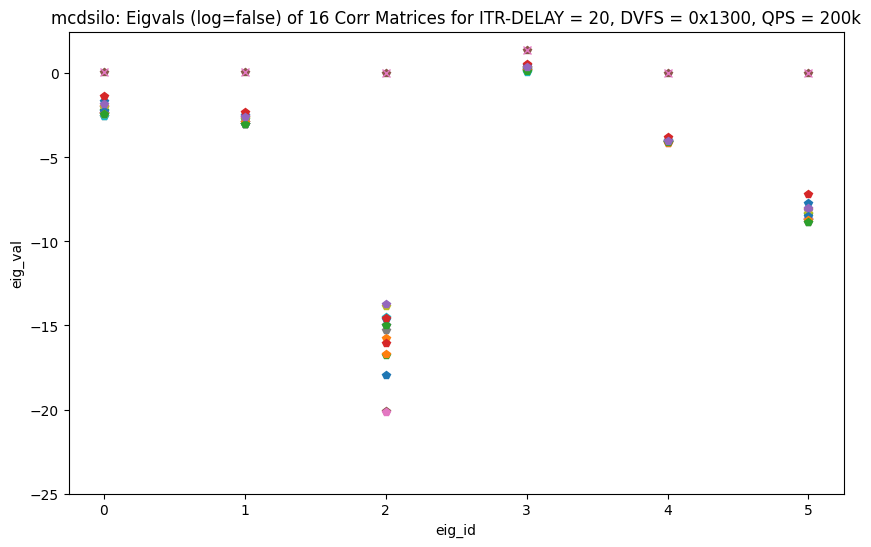

<Figure size 640x480 with 0 Axes>

In [148]:
plot_eig_vals(eig_vals, '0x1300', '200k', '20', app)

Uncompressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_10_0x1300_135_200000.gz:	 81.6% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_10_0x1300_135_200000
Compressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_10_0x1300_135_200000:	 81.6% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_10_0x1300_135_200000.gz
Uncompressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_10_0x1300_135_200000.gz:	 81.1% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_10_0x1300_135_200000
Compressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_10_0x1300_135_200000:	 81.1% -- replaced with mcdsilo_0_rapl_135

Uncompressing merged log files..
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_10_counters_merged.gz:	 65.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_10_counters_merged
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_10_non_counters_merged.gz:	 74.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_10_non_counters_merged
Compressing merged log files..
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_10_counters_merged:	 65.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_10_counters_merged.gz
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_10_non_counters_merged:	 74.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_10_non_counters_merged.gz


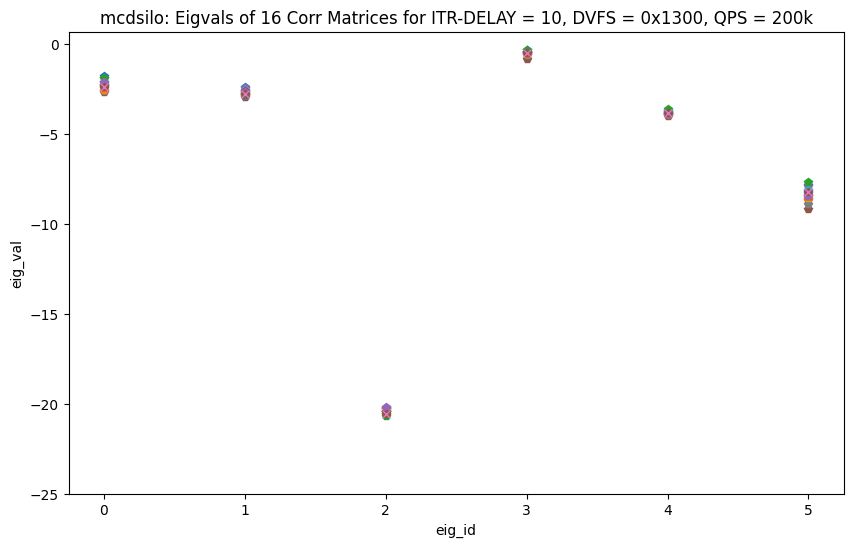

Uncompressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_40_0x1300_135_200000.gz:	 80.2% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_40_0x1300_135_200000
Compressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_40_0x1300_135_200000:	 80.2% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_0_40_0x1300_135_200000.gz
Uncompressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_40_0x1300_135_200000.gz:	 80.1% -- replaced with mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_40_0x1300_135_200000
Compressing log file..
mcdsilo_0_rapl_135/200k_qps/linux_mcdsilo_dmesg_0_0x1300_135_200k/linux.mcdsilo.dmesg.0_1_40_0x1300_135_200000:	 80.1% -- replaced with mcdsilo_0_rapl_135

Uncompressing merged log files..
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_40_counters_merged.gz:	 65.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_40_counters_merged
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_40_non_counters_merged.gz:	 73.6% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_40_non_counters_merged
Compressing merged log files..
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_40_counters_merged:	 65.5% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_counters_merged/0x1300_200k_40_counters_merged.gz
mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_40_non_counters_merged:	 73.6% -- replaced with mcdsilo_0_rapl_135/200k_merged/200k_0x1300_non_counters_merged/0x1300_200k_40_non_counters_merged.gz


<Figure size 640x480 with 0 Axes>

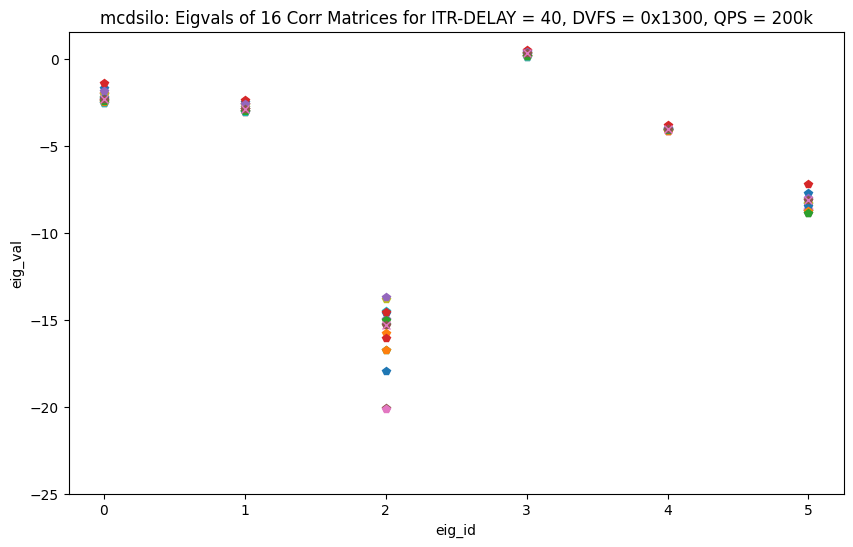

<Figure size 640x480 with 0 Axes>

In [137]:
for dvfs in ['0x1300']:
    for qps in ['200k']:
        for itr in ['10', '40']:
            counters_corr_dict, non_counters_corr_dict = per_core_corr(dvfs, qps, itr, app)
            merged_counters_corr, merged_non_counters_corr = merged_core_corr(dvfs, qps, itr, app)
            eig_vals = get_eig_vals(cores, counters_corr_dict, non_counters_corr_dict, merged_counters_corr, merged_non_counters_corr)
            plot_eig_vals(eig_vals, dvfs, qps, itr, app)